# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
# Import required packages
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import zipfile
import PIL
import pytesseract
import cv2 as cv
import numpy as np

In [2]:
# Extract all images to directory for easier access
with zipfile.ZipFile("readonly/images.zip", "r") as zip_handler:
    zip_handler.extractall('Images')
    f_names = zip_handler.namelist()
    img_paths = {}
    for name in f_names: img_paths[name] = "Images/{}".format(name)

with zipfile.ZipFile("readonly/small_img.zip", "r") as zip_handler:
    zip_handler.extractall('Small_images')
    f_names = zip_handler.namelist()
    sml_img_paths = {}
    for name in f_names: sml_img_paths[name] = "Small_images/{}".format(name)

# Christopher

In [7]:
# Read the extracted images
# dir_path = img_paths  # Directory path containing extracted images.zip files
dir_path = sml_img_paths  # Directory path containing extracted small_img.zip files
img_lst = []  # Store each image as an object
for path in dir_path:
    cv_img = cv.imread(dir_path[path])
    cv_color_img = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv_color_img, "RGB")
    # display(pil_img)
    img_dict = {"pil_img": pil_img, "f_name": path.split("/")[-1]}
    img_lst.append(img_dict)

In [8]:
# Detect texts
search_word = "Christopher"  # "Mark" "Christopher"
for (i, img_dict) in enumerate(img_lst):
    gray = img_dict["pil_img"].convert('1')
    text = pytesseract.image_to_string(gray)
    isPresent = True if search_word in text else False
    img_dict["text"] = isPresent

In [9]:
# Detect faces
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')  # Load the face detection classifier
for (i, img_dict) in enumerate(img_lst):
    img_dict["bboxes"] = []
    img_dict["hasFace"] = False
    if img_dict["text"]:
        pil_gray = img_dict["pil_img"].convert("L")
        cv_gray = np.array(pil_gray)
        # cv_img_bin = cv.threshold(cv_gray, 120, 255, cv.THRESH_BINARY)[1]
        face_bboxes = face_cascade.detectMultiScale(cv_gray, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30))
        if len(face_bboxes) > 0: face_bboxes = face_bboxes.tolist()
        else: continue
        img_dict["bboxes"] = face_bboxes
        hasFace = True if len(face_bboxes) > 0 else False
        img_dict["hasFace"] = hasFace

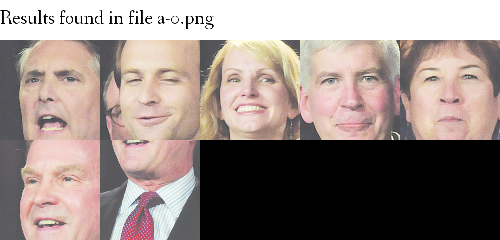

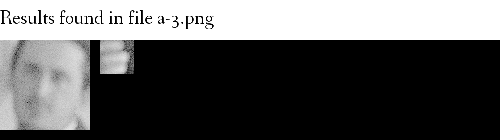

In [10]:
fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 40)  # Font type and font size to use
crop_size = (200, 200)  # Size of image thumbnails
text_height = 80  # Height assigned to text blocks
total_height = 0  # For later concatenation of individual contact sheets
text_offset = 20
contact_sheet_lst = []
for (i, img_dict) in enumerate(img_lst):
    if img_dict["text"]:  # Only make sheets for images with search word in it
        
        # Add the results-reporting texts
        sheet_height = text_height + crop_size[1] * (len(img_dict["bboxes"]) // 5 + 1) if img_dict["hasFace"] else text_height * 2
        total_height += sheet_height
        contact_sheet = PIL.Image.new(img_dict["pil_img"].mode, (crop_size[0] * 5, sheet_height))
        white_block_height = text_height if img_dict["hasFace"] else text_height * 2
        draw_ob = ImageDraw.Draw(contact_sheet)
        draw_ob.rectangle([0, 0, crop_size[0] * 5, white_block_height], fill="white")
        draw_ob.text((0, text_offset), "Results found in file {}".format(img_dict["f_name"]), fill="black", font=fnt)
        if not img_dict["hasFace"]: draw_ob.text((0, text_offset + text_height), "But there were no faces in that file!", fill="black", font=fnt)
        
        # Crop out the faces and arrange the images
        x, y = 0, text_height
        for box in img_dict["bboxes"]:
            (left, top, right, bottom) = box[0], box[1], box[0] + box[2], box[1] + box[3]
            pil_color_img = img_dict["pil_img"].convert("RGB")
            face_img = pil_color_img.crop((left, top, right, bottom))
            face_img.thumbnail(crop_size)
        
            contact_sheet.paste(face_img, (x, y))
            if x + crop_size[0] == crop_size[0] * 5: x, y = 0, y + crop_size[1]
            else: x = x + crop_size[0]

        # Resize and display the contact sheet
        contact_sheet_lst.append(contact_sheet)
        contact_sheet = contact_sheet.resize((int(contact_sheet.width / 2), int(contact_sheet.height / 2) ))
        display(contact_sheet)

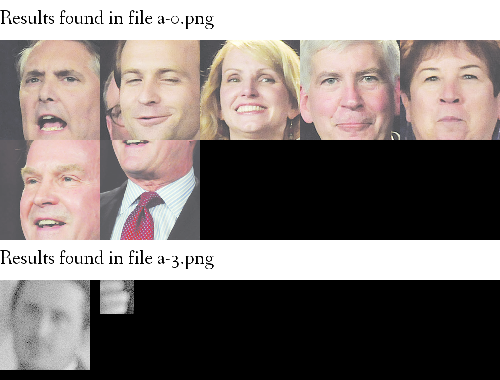

In [11]:
# Stitch all the contact sheets together
final_contact_sheet = PIL.Image.new(contact_sheet_lst[0].mode, (contact_sheet_lst[0].width, total_height))
x, y = 0, 0
for (i, sheet) in enumerate(contact_sheet_lst):
    final_contact_sheet.paste(sheet, (x, y))
    y += sheet.height
    
# Resize and display the contact sheet
final_contact_sheet = final_contact_sheet.resize((int(final_contact_sheet.width / 2), int(final_contact_sheet.height / 2) ))
display(final_contact_sheet)

# Mark

In [3]:
# Read the extracted images
dir_path = img_paths  # Directory path containing extracted images.zip files
# dir_path = sml_img_paths  # Directory path containing extracted small_img.zip files
img_lst = []  # Store each image as an object
for path in dir_path:
    cv_img = cv.imread(dir_path[path])
    cv_color_img = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
    pil_img = Image.fromarray(cv_color_img, "RGB")
    # display(pil_img)
    img_dict = {"pil_img": pil_img, "f_name": path.split("/")[-1]}
    img_lst.append(img_dict)

In [6]:
# Detect texts
search_word = "Mark"  # "Mark" "Christopher"
for (i, img_dict) in enumerate(img_lst):
    gray = img_dict["pil_img"].convert('1')
    text = pytesseract.image_to_string(gray)
    isPresent = True if search_word in text else False
    img_dict["text"] = isPresent

In [39]:
# Detect faces
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')  # Load the face detection classifier
for (i, img_dict) in enumerate(img_lst):
    img_dict["bboxes"] = []
    img_dict["hasFace"] = False
    if img_dict["text"]:
        pil_gray = img_dict["pil_img"].convert("L")
        cv_gray = np.array(pil_gray)
        # cv_img_bin = cv.threshold(cv_gray, 120, 255, cv.THRESH_BINARY)[1]
        face_bboxes = face_cascade.detectMultiScale(cv_gray, scaleFactor=1.3, minNeighbors=4, minSize=(30, 30))
        if len(face_bboxes) > 0: face_bboxes = face_bboxes.tolist()
        else: continue
        img_dict["bboxes"] = face_bboxes
        hasFace = True if len(face_bboxes) > 0 else False
        img_dict["hasFace"] = hasFace

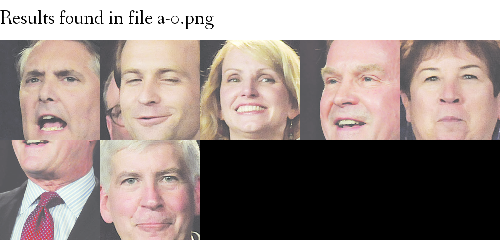

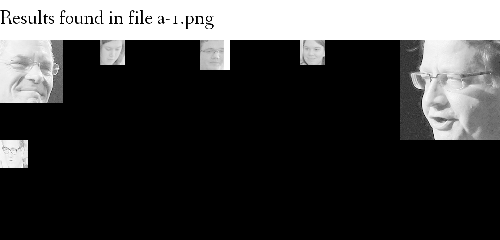

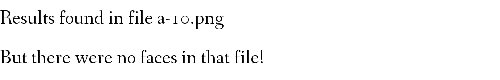

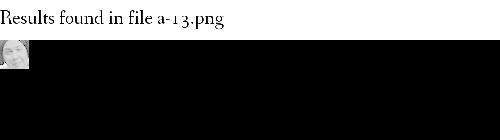

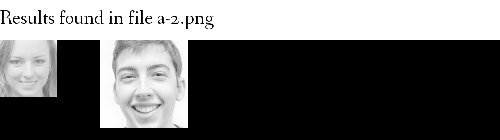

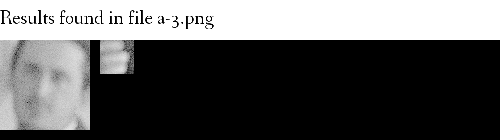

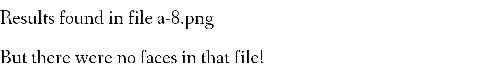

In [40]:
fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 40)  # Font type and font size to use
crop_size = (200, 200)  # Size of image thumbnails
text_height = 80  # Height assigned to text blocks
total_height = 0  # For later concatenation of individual contact sheets
text_offset = 20
contact_sheet_lst = []
for (i, img_dict) in enumerate(img_lst):
    if img_dict["text"]:  # Only make sheets for images with search word in it
        
        # Add the results-reporting texts
        sheet_height = text_height + crop_size[1] * (len(img_dict["bboxes"]) // 5 + 1) if img_dict["hasFace"] else text_height * 2
        total_height += sheet_height
        contact_sheet = PIL.Image.new(img_dict["pil_img"].mode, (crop_size[0] * 5, sheet_height))
        white_block_height = text_height if img_dict["hasFace"] else text_height * 2
        draw_ob = ImageDraw.Draw(contact_sheet)
        draw_ob.rectangle([0, 0, crop_size[0] * 5, white_block_height], fill="white")
        draw_ob.text((0, text_offset), "Results found in file {}".format(img_dict["f_name"]), fill="black", font=fnt)
        if not img_dict["hasFace"]: draw_ob.text((0, text_offset + text_height), "But there were no faces in that file!", fill="black", font=fnt)
        
        # Crop out the faces and arrange the images
        x, y = 0, text_height
        for box in img_dict["bboxes"]:
            (left, top, right, bottom) = box[0], box[1], box[0] + box[2], box[1] + box[3]
            pil_color_img = img_dict["pil_img"].convert("RGB")
            face_img = pil_color_img.crop((left, top, right, bottom))
            face_img.thumbnail(crop_size)
        
            contact_sheet.paste(face_img, (x, y))
            if x + crop_size[0] == crop_size[0] * 5: x, y = 0, y + crop_size[1]
            else: x = x + crop_size[0]

        # Resize and display the contact sheet
        contact_sheet_lst.append(contact_sheet)
        contact_sheet = contact_sheet.resize((int(contact_sheet.width / 2), int(contact_sheet.height / 2) ))
        display(contact_sheet)

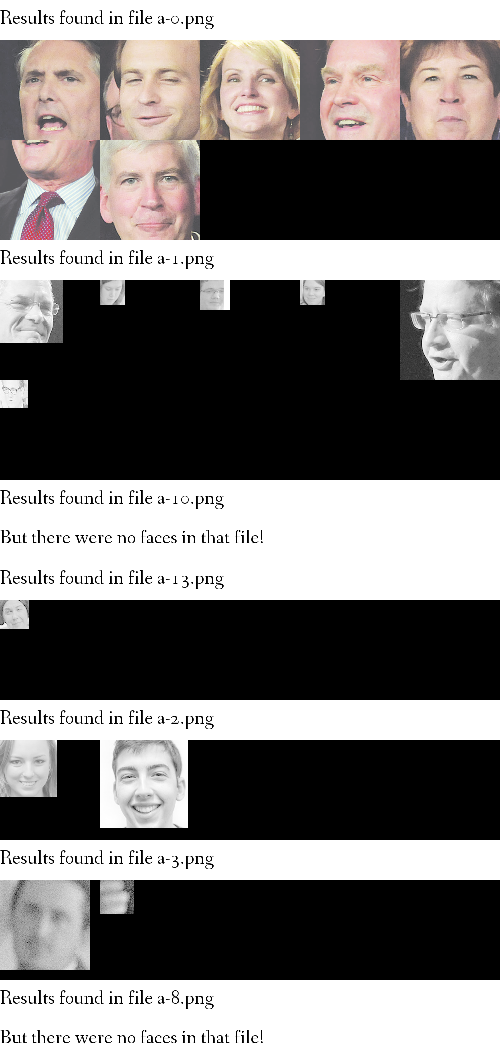

In [41]:
# Stitch all the contact sheets together
final_contact_sheet = PIL.Image.new(contact_sheet_lst[0].mode, (contact_sheet_lst[0].width, total_height))
x, y = 0, 0
for (i, sheet) in enumerate(contact_sheet_lst):
    final_contact_sheet.paste(sheet, (x, y))
    y += sheet.height
    
# Resize and display the contact sheet
final_contact_sheet = final_contact_sheet.resize((int(final_contact_sheet.width / 2), int(final_contact_sheet.height / 2) ))
display(final_contact_sheet)